# Credit Card Customers_Over-Sampling

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline. 

The steps will: 

   - 1. Cleaning, EDA, and Visualization
   - 2. Feature Engineering and Feature Scaling
   - __3. Oversampling__ 
   - 4. Hyperparameter Tuning for Gradient Boosting Model
   - 5. Building Model Pipeline
   
==========================================================================================

### Overview

We've explored data analysis, and found the best methods for feature engineering and feature scaling in the previous notebooks. 

In this notebook, I will use oversampling methods to make dataset balance so that it can help improve model performances. 

We've seen this dataset is an imbalanced data which have more instances of certain classes than of others. So, we need to deal with this very carefully. 

Even though there are a lot of sampling balancing methods (e.g., under-sampling, ensemble sampling), I would like to choose one of the oversampling methods, because we won't lose data by performing over-sampling. 

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard'

In [2]:
# set up path for data
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard/Data/')

In [10]:
# Data pre-processing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Modelling 
from sklearn.metrics import (
    roc_auc_score,
    precision_score, 
    accuracy_score, 
    recall_score,
)

from sklearn.ensemble import RandomForestClassifier


# for feature engineering
from feature_engine import encoding as ce

# Evaluation & CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score


# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


# for oversampling
# for the model 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import encoding as ce

# for oversampling
from sklearn.svm import SVC
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE
)

# for cross-validation
from imblearn.pipeline import make_pipeline

### Load data

In [4]:
df = pd.read_csv(path/'BankChurners.csv')

In [5]:
# drop unuseful columns 
df.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

In [6]:
df.shape

(10127, 20)

In [7]:
df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [8]:
# create lists for categorical and numerical variables
cat_vars = [var for var in df.columns if df[var].dtype=='O' and var != 'Attrition_Flag']
num_vars = [var for var in df.columns if df[var].dtype!='O']

print('The number of categorical variables: {}'.format(len(cat_vars)))
print('The number of numerical vairables: {}'.format(len(num_vars)))

The number of categorical variables: 5
The number of numerical vairables: 14


In [9]:
def run_RFs(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=40, random_state=42, max_depth=3)
    rf.fit(X_train, y_train)
    
    print("Train set")
    train_pred = rf.predict_proba(X_train)
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_train, train_pred[:,1])))
    
    print("Test set")
    test_pred = rf.predict_proba(X_test)
    print("Random Forests roc-auc: {}".format(roc_auc_score(y_test, test_pred[:, 1])))
    
    return roc_auc_score(y_train, train_pred[:,1]), roc_auc_score(y_test, test_pred[:, 1])

### Over-sampling methods

All oversampling methods create new synthetic data from the minority label so that it helps balance data distribution. 

We will try to compare 5 other methods based on the model performances, and choose one of them.  

- RandomOverSampler
- SMOTE
- ADASYN
- BorderlineSMOTE
- SVMSMOTE

First, we need to create oversampler dictionary. 

In [11]:
oversampler_dict = {
    
    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),
    
    'smote': SMOTE(
        sampling_strategy='auto', # samples only the minority class
        random_state=0,
        k_neighbors=5,
        n_jobs=1),
    
    'adasyn': ADASYN(
        sampling_strategy='auto', # samples only the minority class
        random_state=0,
        n_neighbors=5,
        n_jobs=1),
    
    'border1': BorderlineSMOTE(
        sampling_strategy='auto', # samples only the minority class
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=1),
    
    'svm': SVMSMOTE(
        sampling_strategy='auto', # samples only the minority class
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=1,
        svm_estimator=SVC(kernel='linear')),
}


In [14]:
# to save the results
results_dict_over = {}
shapes_dict_over = {}

# separate train and test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Attrition_Flag'], axis=1),
    df['Attrition_Flag'],
    test_size=0.2,
    random_state=0
)

# integer encoding
ordinal_encoding = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars
)

ordinal_encoding.fit(X_train)
X_train = ordinal_encoding.transform(X_train)
X_test = ordinal_encoding.transform(X_test)


# StandardScaler
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

roc = run_RFs(X_train, X_test, y_train, y_test)

# store results
results_dict_over['full_data'] = roc
shapes_dict_over['full_data'] = len(X_train)

print()

for oversampler in oversampler_dict.keys():
    
    print(oversampler)
    
    # resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    # evaluate performance
    roc = run_RFs(X_resampled, X_test, y_resampled, y_test)
    
    # store results
    results_dict_over[oversampler] = roc
    shapes_dict_over[oversampler] = len(X_resampled)
    print()
    
print()

Train set
Random Forests roc-auc: 0.9391798249529026
Test set
Random Forests roc-auc: 0.921798576202566

random
Train set
Random Forests roc-auc: 0.9387144570499972
Test set
Random Forests roc-auc: 0.9208194091824945

smote
Train set
Random Forests roc-auc: 0.9530338342495762
Test set
Random Forests roc-auc: 0.9265718976237999

adasyn
Train set
Random Forests roc-auc: 0.9469218906792373
Test set
Random Forests roc-auc: 0.9354352911019258

border1
Train set
Random Forests roc-auc: 0.9504508228798011
Test set
Random Forests roc-auc: 0.9337248116587787

svm
Train set
Random Forests roc-auc: 0.9494488578115512
Test set
Random Forests roc-auc: 0.9264738866805013




In [18]:
results_dict_over_df = pd.DataFrame(results_dict_over, index=['Train', 'Test']).T

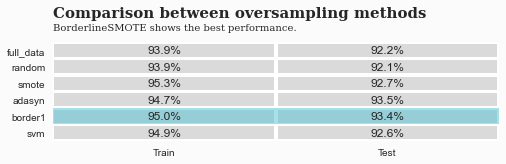

In [27]:
import matplotlib

fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall
#df_models = round(pd.concat([svc_df, dtree_df, rfc_df, tu_rfc_df, log_df, knn_df], axis=1), 3)

sns.heatmap(results_dict_over_df, cmap=colormap, annot=True, fmt=".1%", linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.5, 'Comparison between oversampling methods', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'BorderlineSMOTE shows the best performance.',
        fontfamily='serif', fontsize=10)


from matplotlib.patches import Rectangle
#rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))
rect = ax0.add_patch(Rectangle((0, 4), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))


plt.show()

### Oversampling with Cross Validation

In [30]:
# function to train random forests and evaluate the performance
# with cross-validation

def run_model(X_train, y_train, oversampler=None):
    
    # set up the classifier
    rf = RandomForestClassifier(
            n_estimators=40, random_state=39, max_depth=3, n_jobs=1
        )
    
    
    # without sampling:
    if not oversampler:

        model = rf
    
    # set up a pipeline with sampling:
    else:
        
        # important to scale before the re-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            oversampler,
            rf,
        )
        
          
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the over-sampled data
    
    cv_results = cross_validate(
        model, # the random forest or the pipeline
        X_train, # the data that will be used in the cross-validation
        y_train, # the target
        scoring="roc_auc", # the metric that we want to evaluate
        cv=3, # the cross-validation fold
    )

    #print(
    #    'Random Forests average precision: {0} +/- {1}'.format(
    #    cv_results['test_score'].mean(), cv_results['test_score'].std()
    #    )
    #)
    
    print('RF roc-auc: {}'.format(cv_results['test_score']))

    return cv_results['test_score'] 

In [31]:
# now we train several models, with the different oversamplers 
# and with cross-validation

# to save the results
roc_dict = {}


# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Attrition_Flag', axis=1),
    df['Attrition_Flag'],
    test_size=0.2,
    random_state=0
)

# integer encoding
ordinal_encoding = ce.OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_vars)

ordinal_encoding.fit(X_train)
X_train = ordinal_encoding.transform(X_train)
X_test = ordinal_encoding.transform(X_test)


# StandardScaler
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

# train model on data with re-sampling with cross-validation
test_score = run_model(X_train, y_train)

# store results

roc_dict['full_data'] = test_score

print()


for oversampler in oversampler_dict.keys():
    
    print(oversampler)
    
    # resample, train and evaluate performance
    # with cross-validation
    test_score = run_model(X_train, y_train, oversampler_dict[oversampler])
    
    # store results
    roc_dict[oversampler] = test_score

    print()
    
print()

RF roc-auc: [0.93687829 0.9267348  0.9385802 ]

random
RF roc-auc: [0.92964698 0.93171677 0.93426115]

smote
RF roc-auc: [0.93244793 0.93014007 0.93701761]

adasyn
RF roc-auc: [0.93771712 0.94160314 0.94486988]

border1
RF roc-auc: [0.93677777 0.93749112 0.94873607]

svm
RF roc-auc: [0.92750191 0.93016929 0.93396445]




In [38]:
roc_dict_df = pd.DataFrame(roc_dict, index=['fold1', 'fold2', 'fold3']).T

# calculate the average of test scores
roc_dict_df['mean'] = (roc_dict_df['fold1']+roc_dict_df['fold2']+roc_dict_df['fold3'])/3

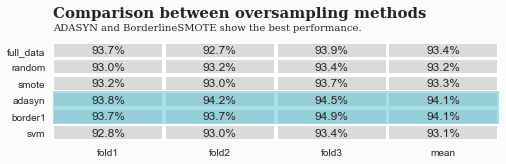

In [42]:
import matplotlib

fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall
#df_models = round(pd.concat([svc_df, dtree_df, rfc_df, tu_rfc_df, log_df, knn_df], axis=1), 3)

sns.heatmap(roc_dict_df, cmap=colormap, annot=True, fmt=".1%", linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.5, 'Comparison between oversampling methods', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'ADASYN and BorderlineSMOTE show the best performance.',
        fontfamily='serif', fontsize=10)


from matplotlib.patches import Rectangle
rect = ax0.add_patch(Rectangle((0, 3), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))
rect = ax0.add_patch(Rectangle((0, 4), 5, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))


plt.show()

### Conclusions

I compared 5 different oversampling methods, and I found ADASYN and BorderlineSMOTE show the best performances. 

I will use ADASYN to balance data when building pipeline for models. 